In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import random_graph
import networkx as nx
import matplotlib.pyplot as plt
import uuid
import pickle
from scipy.signal import convolve
import os
from tqdm import tqdm
import pandas as pd

In [2]:
rng = np.random.default_rng()

In [3]:
# Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [4]:
train_imgs = train_data[:, 1:]  # (60000, 784)
test_imgs = test_data[:, 1:]  # (10000, 784)
train_labels = train_data[:, 0]  # (60000, )
test_labels = test_data[:, 0]  # (10000, )

In [5]:
# Change the top k input values to 1, rest of the values to 0
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [6]:
# EXPERIMENT_STORE = []
# ID_SET = set()

# with open('experiment_store.pickle', 'wb') as f:
#     pickle.dump(EXPERIMENT_STORE, f)

# with open('id_set.pickle', 'wb') as f:
#     pickle.dump(ID_SET, f)

In [7]:
with open('experiment_store.pickle', 'rb') as f:
    EXPERIMENT_STORE = pickle.load(f)

with open('id_set.pickle', 'rb') as f:
    ID_SET = pickle.load(f)

In [71]:
# sample a simple graph, approximately uniformly at random, from all graphs with given degree sequence
# MCMC occurs under the hood

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)

def run_experiment(train_imgs, test_imgs, train_labels, test_labels, verbose=True, **kwargs):
    
    # Sensory area graph
    # Runnable Object for each model

    n_in = kwargs.get('n_in', 784)
    n_neurons = kwargs.get('n_neurons', 2000)
    n_out = n_neurons
    cap_size = kwargs.get('cap_size', 50)
    sparsity = kwargs.get('sparsity', 0.1) # Not Used
    n_rounds = kwargs.get('n_rounds', 5)
    beta = kwargs.get('beta', 1e0)
    n_iter = kwargs.get('n_iter', int(1e6))
    n_examples = kwargs.get('n_examples', 100)
    degree_sequence_A = kwargs['degree_sequence_A']
    degree_sequence_W = kwargs['degree_sequence_W']

    print('printing diags')
    print(n_iter)
    in_s, out_s = zip(*degree_sequence_A)
    print(pd.Series(in_s).describe())
    print(pd.Series(out_s).describe())

    experiment_id = uuid.uuid1()
    while experiment_id in ID_SET:
        experiment_id = uuid.uuid1()
    
    if not os.path.exists('./results'):
        os.mkdir('./results')

    if not os.path.exists(f'./results/{experiment_id}'):
        os.mkdir(f'./results/{experiment_id}')

    A_edges = random_graph.sample_directed_graph(degree_sequence=degree_sequence_A, n_iter=n_iter)
    W_edges = random_graph.sample_directed_graph(degree_sequence=degree_sequence_W, n_iter=n_iter)

    A_graph = nx.DiGraph()
    A_graph.add_nodes_from(range(n_neurons))
    A_graph.add_edges_from(A_edges)

    W_graph = nx.DiGraph()
    W_graph.add_nodes_from(range(n_neurons))
    W_graph.add_edges_from(W_edges)

    if verbose:
        nx.draw(W_graph)
        plt.savefig(f'./results/{experiment_id}/graph_visualization.png')
    
    mask = np.squeeze(np.asarray((nx.linalg.graphmatrix.adjacency_matrix(W_graph).todense() & np.logical_not(np.eye(n_neurons, dtype=bool)))))
    mask_a = np.squeeze(np.asarray((nx.linalg.graphmatrix.adjacency_matrix(A_graph).todense() & np.logical_not(np.eye(n_neurons, dtype=bool)))))

    W = np.ones((n_neurons, n_neurons)) * mask
    W /= W.sum(axis=0)
    A = np.ones((n_in, n_neurons)) * mask_a
    A /= A.sum(axis=0)

    W = W.astype(np.float64)
    A = A.astype(np.float64)[:n_in, :n_neurons]


    # n_in = 784
    # n_neurons = 2000
    # cap_size = 200
    # sparsity = 0.1
    # n_rounds = 5
    # beta = 1e0

    # mask = np.zeros((n_neurons, n_neurons), dtype=bool)
    # W = np.zeros((n_neurons, n_neurons))

    # mask_a = np.zeros((n_in, n_neurons), dtype=bool)
    # A = np.zeros((n_in, n_neurons))

    # # Random mask on inter-area connections
    # # Choose 10% of connections and not the diagnal
    # mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
    # W = np.ones((n_neurons, n_neurons)) * mask
    # W /= W.sum(axis=0)

    # # Random mask on input-learning area connections
    # mask_a = rng.random((n_in, n_neurons)) < sparsity
    # A = np.ones((n_in, n_neurons)) * mask_a
    # A /= A.sum(axis=0)



    # k-cap on convolved input pixels
    n_examples = 500
    examples = np.zeros((10, n_examples, 784))
    for i in range(10):
        examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)

    # Init connections from each neuron to sum up to 1
    W = np.ones_like(W)
    A = np.ones_like(A)
    W /= W.sum(axis=0, keepdims=True)
    A /= A.sum(axis=0, keepdims=True)
    bias = np.zeros(n_neurons)
    b = -1
    activations = np.zeros((10, n_rounds, n_neurons))

    print('printing arrays')
    print(W)
    print(A)

    # Loop over each class
    for i in range(10):
        act_h = np.zeros(n_neurons)
        
        # Loop over several examples
        for j in range(n_rounds):
            input = examples[i, j]
            
            # calculate activation
            # print(W.shape)
            # print(A.shape)
            act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
            activations[i, j] = act_h_new.copy()
            
            # update weights
            A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            
            act_h = act_h_new
            
        bias[act_h > 0] += b
        A /= A.sum(axis=0, keepdims=True)
        W /= W.sum(axis=0, keepdims=True)


    outputs = np.zeros((10, n_rounds+1, n_examples, n_neurons))
    for i in np.arange(10):
        # Run each example through the model n_round times
        for j in range(n_rounds):
            outputs[i, j+1] = k_cap(outputs[i, j] @ W + examples[i] @ A, cap_size)

    idx = np.full(n_neurons, -1, dtype=int)
    act = activations[:, -1].copy()       # final state activation after training each class
    act.shape

    for i, j in enumerate(range(10)):
        idx[i*cap_size:(i+1)*cap_size] = act[j].argsort()[-cap_size:][::-1]
        act[:, idx[i*cap_size:(i+1)*cap_size]] = -1
    
    r = np.arange(n_neurons)
    r[idx[idx > -1]] = -1
    idx[(i+1)*cap_size:] = np.unique(r)[1:]

    if verbose:
        get_ipython().run_line_magic('matplotlib', 'inline')

        fig, axes = plt.subplots(10, n_rounds, figsize=(10, 2 * 10), sharex=True, sharey=True)
        for ax, output in zip(axes, outputs):
            for i in range(n_rounds):
                ax[i].imshow((output[i+1] > 0)[:n_neurons, idx])
                ax[i].set_axis_off()
        fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
        fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')
        plt.savefig(f'./results/{experiment_id}/neuron_activation_grid.png')
    
    v = 0.1 * rng.standard_normal((10, n_neurons))
    targets = np.zeros((100, 10))

    for i in range(10):
        targets[i*10:(i+1)*10, i] = 1
    update = np.zeros_like(v)

    for z in range(10):
        permutation = rng.permutation(n_examples - 1000)
        # print(f'{z}th iteration')

    for j in range((n_examples - 1000) // 10):
        batch = outputs[:, 1, permutation[j*10:(j+1)*10]].reshape(10 * 10, n_neurons)
        scores = softmax((batch[:, :, np.newaxis] * v.T[np.newaxis, :, :]).sum(axis=1))
        update = 0.5 * update + 1e-3 * (batch[:, np.newaxis, :] * (scores - targets)[:, :, np.newaxis]).sum(axis=0)
        v -= update

    if verbose:
        fig, ax = plt.subplots(figsize=(10, 4))
        for i in range(10):
            # Pass each sample to the model and get its result 
            ax.bar(np.arange(n_neurons), outputs[i, -1].mean(axis=0)[idx], label=i)
        ax.legend(loc='upper right', ncol=2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim([0, 1.1])
        ax.set_xticklabels([])
        ax.set_xlabel('Neurons')
        ax.set_ylabel('Firing Probability')
    
        plt.savefig(f'./results/{experiment_id}/firing_probability.png')

    # c is a mask for identifying each assembly
    # set top k neurons to value 1 and 0 otherwise 
    c = np.zeros((10, n_neurons))
    use_train_act = True

    for i in range(10):
        
        if use_train_act:
            # create mask based on the last activation of each class during training
            c[i, activations[i, -1].argsort()[-cap_size:]] = 1
        else:
            # create mask based on the activation after 1 round of ALL the samples for each class
            c[i, outputs[i, 1].sum(axis=0).argsort()[-cap_size:]] = 1
            

    if verbose:
        fig, axes = plt.subplots(1, 10, figsize=(10, 2))
        for i in range(10):
            axes[i].imshow((A * c[i][np.newaxis, :]).sum(axis=1).reshape(28, 28))
            axes[i].set_axis_off()
        fig.tight_layout()
    
        plt.savefig(f'./results/{experiment_id}/digit_representation.png')

 
    predictions = (outputs[:, 1] @ c.T).argmax(axis=-1)
    acc = (predictions == np.arange(10)[:, np.newaxis]).sum(axis=-1) / n_examples
    
    if verbose:
        print(f'Accuracy: {acc.mean()}')
        print(f'Accuracy per class: {acc}')

    results = {
        'experiment_id': experiment_id,
        'parameters': {
            'degree_sequence_A': degree_sequence_A,
            'degree_sequence_W': degree_sequence_W,
            'scaling_factor': scaling_factor,
        },
        'training_first_n': ((outputs[:, 1, :-1000] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 40000,
        'training_last_n': ((outputs[:, 1, -1000:] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 10000,
        'acc': acc, 
        'acc_mean': acc.mean(),
    }

    EXPERIMENT_STORE.append(results)

    with open('experiment_store.pickle', 'wb') as f:
        pickle.dump(EXPERIMENT_STORE, f)

    with open('id_set.pickle', 'wb') as f:
        pickle.dump(ID_SET, f)

    return results


## Manually defined degree sequences experiment

## Considerations
1. 0 in degree 0 out degree nodes
2. heterogenaity rate
3. Amount the in degree and out degree are misaligned

In [72]:
degree_sequences = [
    list((np.array((200,) * 10 + (100,) * 25 + (50,) * 50 + (25,) * 100 + (20,) * 250 + (10,) * 400 + (5,) * 500 + (1,) * 665)/2).round().astype(int)),
    list(np.array((100,) * 8 + (80,) * 12 + (50,) * 20 + (30,) * 30 + (20,) * 50 + (15,) * 75 + (10,) * 100 + (5,) * 200 + (2,)*600 + (1,) * 905))
]

In [73]:
len(degree_sequences[0])

2000

## Distribution generated degree sequences experiment

In [74]:
from scipy.stats import beta
from scipy.stats import uniform
from scipy.stats import binom

In [75]:
def generate_degree_sequences(distribution, n_neurons, desired_connections, verbose=False, **kwargs):
    samples_transformed = None
    if distribution == 'beta':
        if 'a' not in kwargs.keys() or 'b' not in kwargs.keys():
            raise ValueError('Need alpha or beta args')
        
        samples = beta.rvs(kwargs['a'], kwargs['b'], size=n_neurons)
        normalized_samples = samples/sum(samples)
        samples_transformed = (normalized_samples*(desired_connections-1)+1).round()
    elif distribution == 'uniform':
        samples = uniform.rvs(size=n_neurons)
        normalized_samples = samples/sum(samples)
        samples_transformed = (normalized_samples*(desired_connections-1)+1).round()
    elif distribution == 'binomial':
        if 'n' not in kwargs.keys() or 'p' not in kwargs.keys():
            raise ValueError('Need n or p args')

        samples = binom.rvs(n=kwargs['n'], p=kwargs['p'], size=n_neurons)
        normalized_samples = samples/sum(samples)
        samples_transformed = (normalized_samples*(desired_connections-1)+1).round()
    else:
        raise NotImplementedError()

    if samples_transformed is not None:
        if verbose:
            plt.hist(samples_transformed, density=True, histtype='stepfilled', alpha=0.2)
            plt.show()
            print(sum(samples_transformed))
            print(max(samples_transformed))
            print(min(samples_transformed))
            print(sum(samples_transformed))
            print(sum(samples_transformed)/len(samples_transformed))
            print() 
        return list(samples_transformed.astype(np.int32))
    else:
        raise ValueError('Samples transformed is empty')


In [76]:
import random
def scale_degree_sequences(degree_sequence_W_in, degree_sequence_W_out, scaling_factor, n_swaps=500):

    def index_to_frequency_list(seq, neurons):
        freq_list = [0] * neurons
        for i in seq:
            freq_list[i] += 1
        return freq_list

    def swap_random(seq, n):
        for i in range(n):
            idx = range(len(seq))
            i1, i2 = random.sample(idx, 2)
            seq[i1], seq[i2] = seq[i2], seq[i1]
        return seq

    final_degree_sequence_W_in = list((np.array(degree_sequence_W_in) * scaling_factor).round().astype(int))
    final_degree_sequence_W_out = list((np.array(degree_sequence_W_out) * scaling_factor).round().astype(int))

    in_sum = sum(final_degree_sequence_W_in)
    out_sum = sum(final_degree_sequence_W_out)

    total_neurons = len(degree_sequence_W_in)

    if in_sum > out_sum:
        number_nodes_to_add = in_sum - out_sum
        normalized_out_sum = [i/sum(final_degree_sequence_W_out) for i in final_degree_sequence_W_out]
        degrees_to_add = np.random.choice(total_neurons, p=normalized_out_sum, size=number_nodes_to_add)
        list_to_add = index_to_frequency_list(degrees_to_add, total_neurons)
        final_degree_sequence_W_out = np.array(list_to_add, dtype=np.int64) + final_degree_sequence_W_out
    else:
        number_nodes_to_add = out_sum - in_sum
        normalized_in_sum = [i/sum(final_degree_sequence_W_in) for i in final_degree_sequence_W_in]
        degrees_to_add = np.random.choice(total_neurons, p=normalized_in_sum, size=number_nodes_to_add)
        list_to_add = index_to_frequency_list(degrees_to_add, total_neurons)
        final_degree_sequence_W_in = np.array(list_to_add, dtype=np.int64) + final_degree_sequence_W_in

    final_degree_sequence_W_in = list(final_degree_sequence_W_in)
    final_degree_sequence_W_out = list(final_degree_sequence_W_out)
    final_degree_sequence_W_out = swap_random(final_degree_sequence_W_out, n_swaps)

    # print(sum(final_degree_sequence_W_out))
    # print(sum(final_degree_sequence_W_in))
    assert sum(final_degree_sequence_W_out) == sum(final_degree_sequence_W_in)
    
    final_degree_sequence_W = list(zip(final_degree_sequence_W_in, final_degree_sequence_W_out)) # Convert from zip to list
    return final_degree_sequence_W

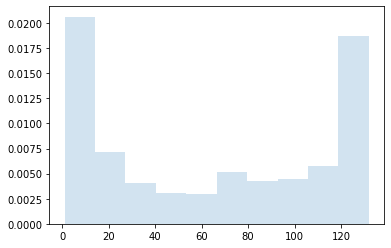

50768.0
132.0
1.0
50768.0
64.75510204081633



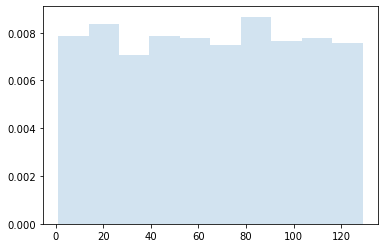

50775.0
129.0
1.0
50775.0
64.7640306122449



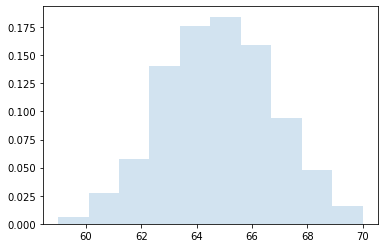

50774.0
70.0
59.0
50774.0
64.76275510204081



In [77]:
example_beta_degree_sequences = generate_degree_sequences('beta', 784, 50000, a=0.4, b=0.4, verbose=True)

example_uniform_degree_sequences = generate_degree_sequences('uniform', 784, 50000, verbose=True)

example_binomial_degree_sequences = generate_degree_sequences('binomial', 784, 50000, n=5000, p=0.2, verbose=True)

example_degree_sequences = [example_uniform_degree_sequences, example_beta_degree_sequences, example_binomial_degree_sequences]

In [78]:
iteration_list = []
for degree_sequence_W_in in example_degree_sequences:
    for degree_sequence_W_out in example_degree_sequences:
        for scaling_factor in [1, 1.2]:
            iteration_list.append({
                'degree_sequence_in': degree_sequence_W_in,
                'scaling_factor': scaling_factor,
                'degree_sequence_out': degree_sequence_W_out,
            })
for params in tqdm(iteration_list):
    scaling_factor = params['scaling_factor']
    degree_sequence_W_in = params['degree_sequence_in']
    degree_sequence_W_out = params['degree_sequence_out']
    final_degree_sequence_W = scale_degree_sequences(degree_sequence_W_in, degree_sequence_W_out, scaling_factor, n_swaps=100)
    W, A = run_experiment(train_imgs, test_imgs, train_labels, test_labels, verbose=True, degree_sequence_W=final_degree_sequence_W, degree_sequence_A=final_degree_sequence_W, n_neurons=len(final_degree_sequence_W), n_iter=25, cap_size=50, n_examples=100)
    break

  0%|          | 0/18 [00:00<?, ?it/s]

printing diags
25
count    784.000000
mean      64.764031
std       37.317206
min        1.000000
25%       32.000000
50%       65.000000
75%       96.000000
max      129.000000
dtype: float64
count    784.000000
mean      64.764031
std       37.317206
min        1.000000
25%       32.000000
50%       65.000000
75%       96.000000
max      129.000000
dtype: float64


In [ ]:
W.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
EXPERIMENT_STORE

[{'experiment_id': UUID('030704ac-583b-11ec-9c8f-a683e7c9b40b'),
  'parameters': {'degree_distribution': [100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
  

In [57]:
for experiment in EXPERIMENT_STORE:
    if 'degree_distribution' in experiment.keys():
        print(np.array(experiment['parameters']['degree_distribution']))
        print(experiment['acc'])
        print(experiment['acc_mean'])

In [ ]:
EXPERIMENT_STORE

[{'experiment_id': UUID('030704ac-583b-11ec-9c8f-a683e7c9b40b'),
  'parameters': {'degree_distribution': [100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    80,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    50,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    30,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
  